In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import mygene

# Analysis of TCGA Tumor vs Normal Differential Expression

Using data produced from this experiment: <br>
https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/tcga_matched.py 

### Number of samples

In [3]:
def zip_sort(x, y):
    vals = sorted(zip(x, y), key=lambda x: x[1])
    return zip(*vals)

def label_fix(l):
    return [x.replace('_', '\n').capitalize() for x in l]

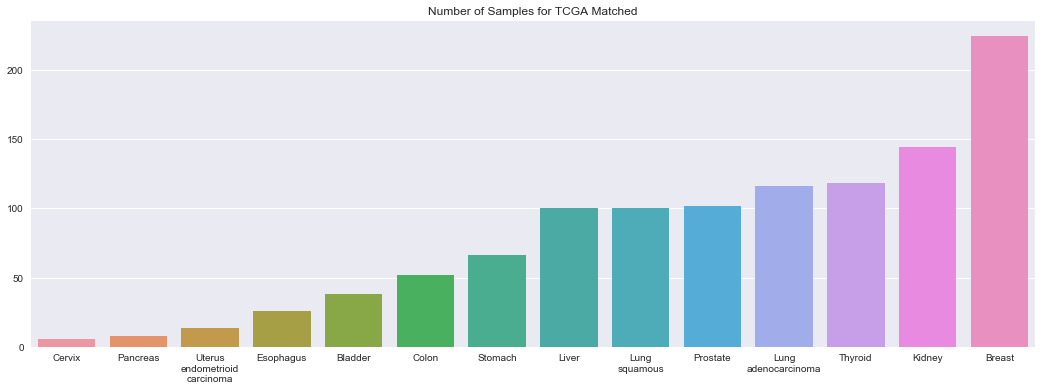

In [95]:
vector_names = [x.split('-vector')[0].replace('_', '\n').capitalize() for x in os.listdir('vectors/')]
num_samples = [len(open(os.path.join('vectors', x)).readlines()) for x in os.listdir('vectors/')]

vector_names, num_samples = zip_sort(vector_names, num_samples)

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(vector_names, num_samples, ax=ax)
plt.title('Number of Samples for TCGA Matched');

### Significant Genes

Read in results from DESeq2

In [4]:
result_paths = [x for x in os.listdir('results') if '.tsv' in x]
results = {}
for result in result_paths:
    results[result.split('-')[0]] = pd.read_csv(os.path.join('results', result), index_col=0, sep='\t')

In [8]:
results['cervix'].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geneId
KRT16,135944.878832,8.597716,0.613945,14.004042,1.472522e-44,2.495778e-40,ENSG00000186832.8
PITX1,6510.860724,8.624863,0.624419,13.812628,2.138850e-43,1.812568e-39,ENSG00000069011.15
KRT80,7326.236941,7.598570,0.586937,12.946140,2.470680e-38,1.395852e-34,ENSG00000167767.13
LONRF2,3602.704383,-7.765299,0.606445,-12.804613,1.544949e-37,5.237069e-34,ENSG00000170500.12
DES,112064.272393,-8.411240,0.656821,-12.805989,1.517804e-37,5.237069e-34,ENSG00000175084.11


Positive log2FoldChange are gain of function for TUMOR <br>
Negative log2FoldChnage are loss of function for TUMOR

In [14]:
sig_genes = {x: results[x][results[x].padj < 0.001].index for x in [y.split('-')[0] for y in result_paths]}

Q: Number of significant genes for each tissue?

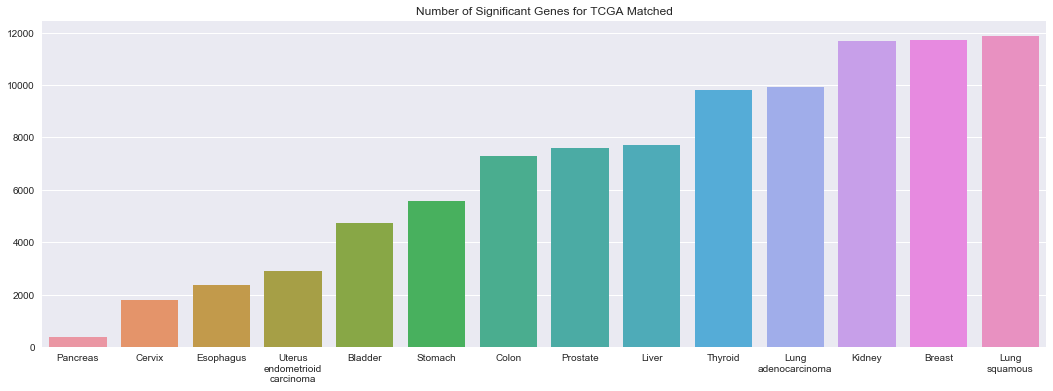

In [89]:
genes = [x.replace('_', '\n').capitalize() for x in sig_genes.keys()]
x, y = zip_sort(genes, [len(sig_genes[x]) for x in sig_genes.keys()])

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(x, y, ax=ax)
plt.title('Number of Significant Genes for TCGA Matched');

## Correlation between Sample Size and Sig Genes

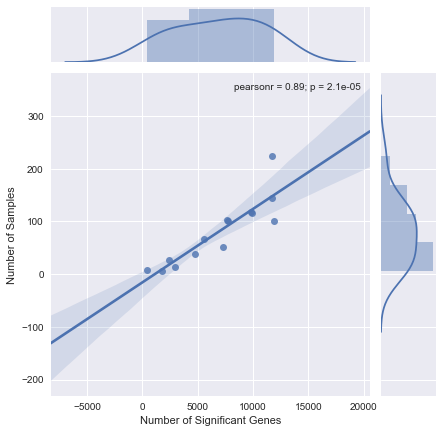

In [93]:
num_samples = np.array([len(open(os.path.join('vectors', x)).readlines()) for x in sorted(os.listdir('vectors/'))])
num_sig = np.array([len(sig_genes[x]) for x in sorted(sig_genes.keys())])
sns.jointplot(num_sig, num_samples, kind='reg')
plt.xlabel('Number of Significant Genes')
plt.ylabel('Number of Samples');

## Overlap Heatmap

In [47]:
n = 100
top_hits = {x: results[x].head(n).index for x in [y.split('-')[0] for y in result_paths]} 

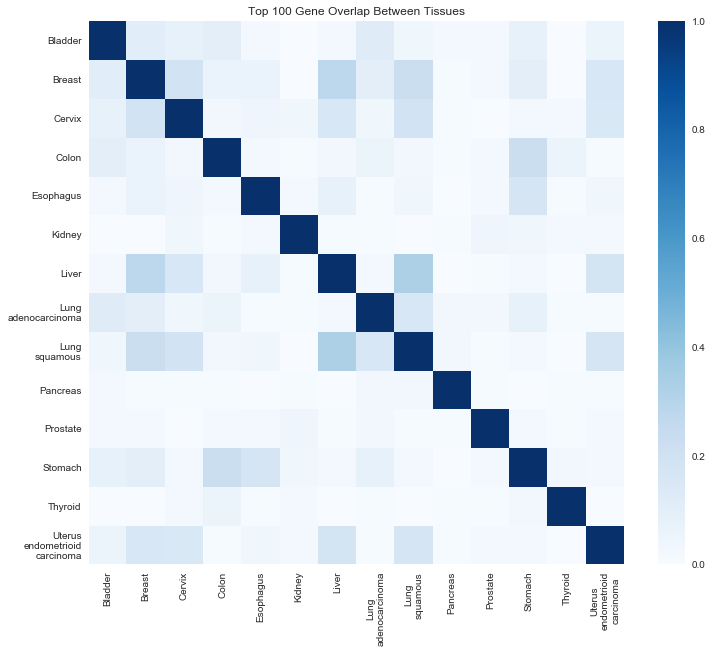

In [48]:
overlap = []
for tissue in df.index:
    overlap.append([float(len(set(top_hits[tissue]).intersection(set(top_hits[x]))))/n for x in df.index])
overlap = pd.DataFrame(overlap)
overlap.index = label_fix(df.index)
overlap.columns = label_fix(df.index)

fig, ax = plt.subplots(figsize=[12,10])
sns.heatmap(overlap, ax=ax, cmap='Blues')
plt.title('Top {} Gene Overlap Between Tissues'.format(n));

In [61]:
lung_genes = list(set(top_hits['lung_squamous']).intersection(set(top_hits['lung_adenocarcinoma'])))
print '\n'.join(lung_genes)

FAM107A
ACVRL1
INMT
JAM2
CLEC3B
S1PR1
ERCC6L
FERMT1
RAMP2
LDB2
USHBP1
TEK
GPD1
KANK3
CLIC5
TOP2A


## Gene Annotation

In [44]:
def get_basic_gene_info(gene_list):
    mg = mygene.MyGeneInfo()
    return mg.querymany(gene_list, 
                        scopes='symbol', 
                        fields='symbol,name,entrezgene,summary', 
                        species='human', 
                        returnall=True, 
                        as_dataframe=True, 
                        size=1)

## Write Out Values

In [75]:
try:
    os.mkdir('analysis')
    os.mkdir('analysis/sig-genes')
    os.mkdir('analysis/top-100-genes')
    os.mkdir('analysis/annotations')
except OSError:
    pass

#### Significantly Expressed Genes

In [76]:
sig_path = 'analysis/sig-genes'
for result in results:
    df = results[result]
    sig_genes = df[df.padj < 0.001]
    upreg = sig_genes[sig_genes.log2FoldChange > 0]
    downreg = sig_genes[sig_genes.log2FoldChange < 0]
    with open(os.path.join(sig_path, result + '-upreg.txt'), 'w') as f:
        f.write('\n'.join(upreg.index))
    with open(os.path.join(sig_path, result + '-downreg.txt'), 'w') as f:
        f.write('\n'.join(downreg.index))

#### Top Genes

In [7]:
top_path = 'analysis/top-100-genes'
for result in results:
    df = results[result]
    df = df.head(100)
    with open(os.path.join(top_path, result + '.txt'), 'w') as f:
        f.write('\n'.join(df.index))

#### Annotations

In [81]:
annotations_path = 'analysis/annotations'
for result in results:
    df = results[result]
    sig_genes = df[df.padj < 0.001]
    upreg = sig_genes[sig_genes.log2FoldChange > 0].index
    downreg = sig_genes[sig_genes.log2FoldChange < 0].index
    # Query gene server
    up_info = get_basic_gene_info(upreg)
    up_info['out'].to_csv(os.path.join(annotations_path, result + '-up-annotations.tsv'), sep='\t')
    down_info = get_basic_gene_info(downreg)
    down_info['out'].to_csv(os.path.join(annotations_path, result + '-down-annotations.tsv'), sep='\t')        

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4965...done.
Finished.
3 input query terms found dup hits:
	[(u'ADORA3', 2), (u'FAM47E-STBD1', 2), (u'SOGA3', 2)]
79 input query terms found no hit:
	[u'PVRL4', u'SLMO1', u'C19orf26', u'FAM132A', u'LPPR3', u'CCDC64B', u'PPAP2C', u'AL589743.1', u'KIAA
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4867...done.
Finished.
5 input query terms found dup hits:
	[(u'PI4K2B', 2), (u'CLN3', 2), (u'RPP14', 2), (u'SNURF', 2), (u'SERPINA3', 2)]
90 input query terms found no hit:
	[u'PRUNE', u'C10orf32', u'ERO1LB', u'FAM63A', u'CCDC176', u'C5orf28', u'C6orf165', u'NDNL2', u'CCDC6
querying 1-781...done.
Finished.
9 input query terms found no hit:
	[u'SGOL1', u'CASC5', u'KIAA0101', u'PVRL4', u'CCDC64', u'PVRL1', u'C11orf85', u'MLK4', u'CGB']
querying 1-996...done.
Finished.
9 input query terms found no hit:
	[u'F